In [263]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
from pyMRI.utils import RMSE

In [264]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
# ws, t2s, M_0s = ws[met_i:met_i + 1], t2s[met_i:met_i + 1], M_0s[met_i:met_i + 1]
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


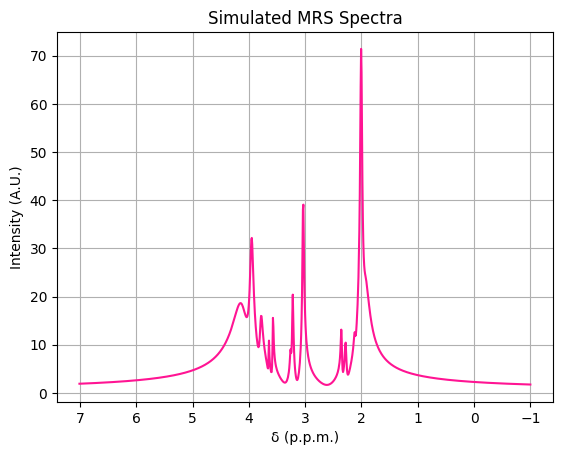

In [265]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [266]:
L = 0.4
L_ = int(L*sig.size)
rcond = 1e-15
zero_filtering=1e-30

In [269]:
sample_snrs = np.array([0.25, 0.50, 0.75, 1.0, 2.5, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0])
SNR = sample_snrs[6]
print(SNR)

10.0


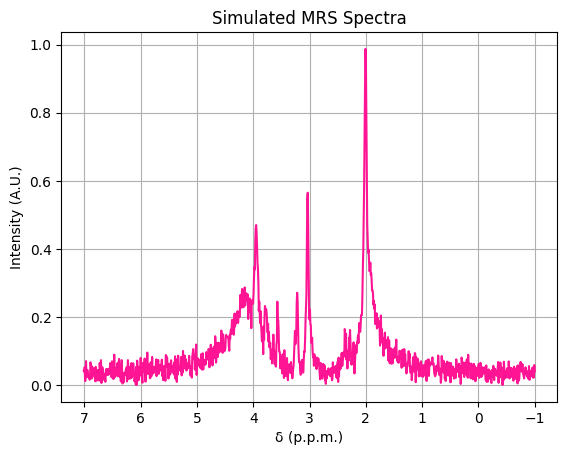

In [270]:
sig_fft_ = sig_fft/np.nanmax(sig_fft)

c_sig_fft = awgn(sig_fft_, SNR)
c_sig = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

pymri.plot_chem_shifts(freqs, c_sig_fft, 1.0)

In [255]:
f_sig, z, r = pymri.filter_sig(c_sig, L, 30.0, 
                                return_poles_and_res=True, 
                                return_full_arrays=True, 
                                rcond=rcond, 
                                zero_filtering=zero_filtering)

s0s_, phis_, omegas_, t2s_ = pymri.calculate_variables_from_z_and_r(z, r, dt)
t2s_ = 1/t2s_

In [256]:
lower_order = -1.3
higher_order = -0.5

In [257]:
lower_order_arr = np.log10(np.abs(t2s_)) <= lower_order
higher_order_arr = np.log10(np.abs(t2s_)) > higher_order
negative_arr = t2s_ <= 0.0
t2_filter_arr = np.bitwise_and( np.bitwise_and( np.bitwise_not(lower_order_arr), np.bitwise_not(higher_order_arr) ), np.bitwise_not(negative_arr))

print("T2")
print(f"Ordem absoluta menor que {lower_order}\t : {t2s_[lower_order_arr].size}")
print(f"Ordem absoluta maior que {higher_order}\t : {t2s_[higher_order_arr].size}")
print(f"Negativos\t\t\t: {t2s_[negative_arr].size}")
print(f"Restantes\t\t\t: {t2s_[t2_filter_arr].size}")

T2
Ordem absoluta menor que -1.3	 : 45
Ordem absoluta maior que -0.5	 : 505
Negativos			: 109
Restantes			: 267


In [258]:
limit_omega = pymri.max_frequency(dt)
possible_omegas_arr = pymri.rad_to_hz(omegas_) <= limit_omega

filter_arr = np.bitwise_and(t2_filter_arr, possible_omegas_arr)

In [259]:
filtered_s0, filtered_phi, filtered_omega, filtered_t2 = s0s_[filter_arr], phis_[filter_arr], omegas_[filter_arr], t2s_[filter_arr]

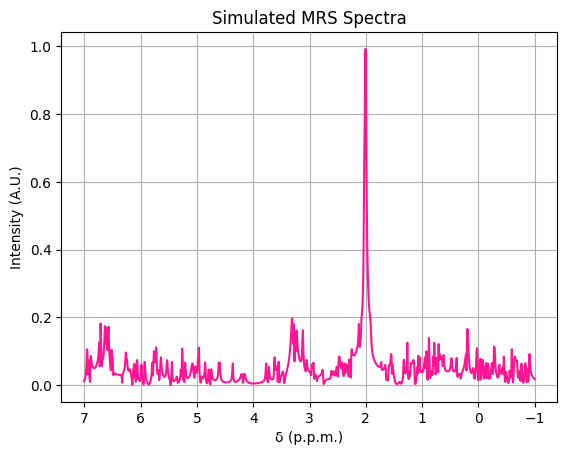

In [260]:
pop2 = pymri.population(filtered_omega, filtered_t2, filtered_s0, filtered_phi)
# pop2 = pymri.population(omegas_, t2s_, s0s_, phis_)

sig2, t = pymri.population_transverse_decay( t0, tn, dt, pop2)


freqs, sig_fft2 = pymri.fourier_spectrum( sig2, dt, B0 )

pymri.plot_chem_shifts(freqs, sig_fft2)

In [261]:
arr = filtered_s0*filtered_t2

loc = arr == np.max(arr)

print(filtered_omega[loc])

[2411.39058328]


Aqui, usou-se a ideia de que o maior pico seria o com maio valor de s0 e de t2, duas variáveis que definem tamanho de pico. O máximo da multiplicação dos dois definiria o maior pico.

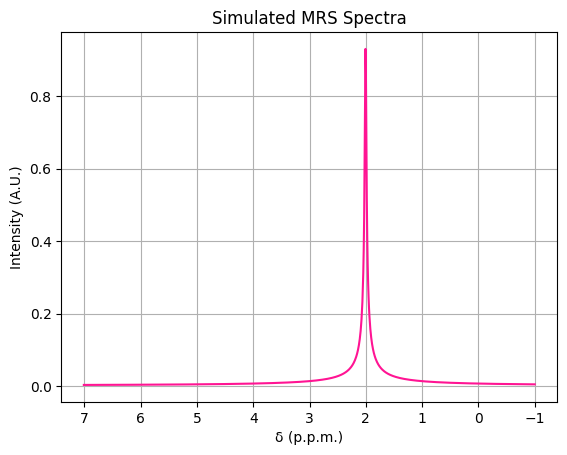

In [262]:
pop3 = pymri.population(filtered_omega[loc], filtered_t2[loc], filtered_s0[loc], filtered_phi[loc])

sig3, t = pymri.population_transverse_decay( t0, tn, dt, pop3)


freqs, sig_fft3 = pymri.fourier_spectrum( sig3, dt, B0 )

pymri.plot_chem_shifts(freqs, sig_fft3)